In [ ]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2022-05-26 16:54:52--  https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-gzip]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M  2.57MB/s    in 11s     

2022-05-26 16:55:04 (2.12 MB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tqdm.auto import tqdm

Delete broken images

In [ ]:
fold_pets = os.listdir('petfaces')
deleted_count = 0

for folder_name in tqdm(fold_pets):
  folder_path = os.path.join("petfaces", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      deleted_count += 1
      os.remove(fpath)

print("Deleted %d images" % deleted_count)

  0%|          | 0/35 [00:00<?, ?it/s]

Deleted 0 images


In [ ]:
from PIL import Image

Image.open('/content/petfaces/cat_Abyssinian/Abyssinian_101.jpg').size

(265, 199)

Create dataset

In [ ]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './petfaces',
    validation_split=0.2,
    subset='training',
    seed=20,
    image_size=image_size,
    batch_size=batch_size,
    class_names=fold_pets,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './petfaces',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=fold_pets,
)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


In [ ]:
validation_size = 642

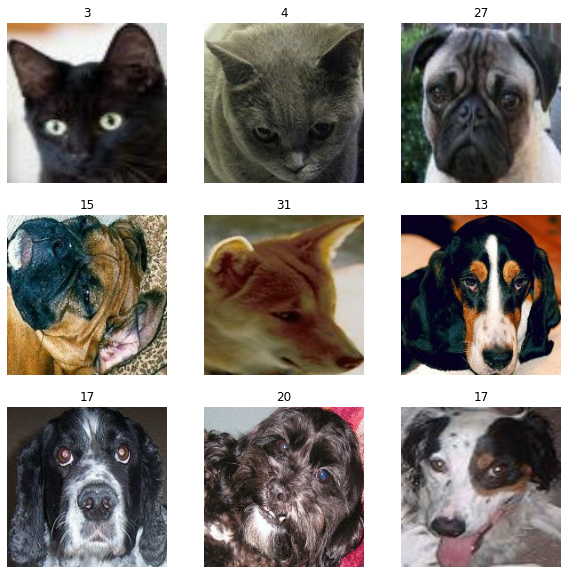

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Augmentation (https://www.tensorflow.org/tutorials/images/data_augmentation)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

CNN model

In [ ]:
model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  layers.Dense(128, activation='relu'),
  layers.Dense(35)
])

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-03),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
epochs = 15

model.fit(
    train_ds, 
    validation_data=val_ds,    
    epochs=epochs
)

Epoch 1/15
81/81 [==============================] - 8s 63ms/step - loss: 3.4820 - accuracy: 0.0627 - val_loss: 3.0704 - val_accuracy: 0.1371
Epoch 2/15
81/81 [==============================] - 5s 60ms/step - loss: 2.5803 - accuracy: 0.2845 - val_loss: 1.9107 - val_accuracy: 0.4502
Epoch 3/15
81/81 [==============================] - 6s 73ms/step - loss: 1.6375 - accuracy: 0.5313 - val_loss: 1.4141 - val_accuracy: 0.6121
Epoch 4/15
81/81 [==============================] - 7s 79ms/step - loss: 1.0524 - accuracy: 0.6863 - val_loss: 1.0782 - val_accuracy: 0.7150
Epoch 5/15
81/81 [==============================] - 7s 77ms/step - loss: 0.6391 - accuracy: 0.8015 - val_loss: 1.0718 - val_accuracy: 0.7461
Epoch 6/15
81/81 [==============================] - 6s 60ms/step - loss: 0.4125 - accuracy: 0.8649 - val_loss: 0.7359 - val_accuracy: 0.8567
Epoch 7/15
81/81 [==============================] - 7s 79ms/step - loss: 0.2886 - accuracy: 0.9042 - val_loss: 0.7509 - val_accuracy: 0.8567
Epoch 8/15
81

testing on random images

In [ ]:
import numpy as np

dog_pug_with_ = 'https://images.saymedia-content.com/.image/t_share/MTc0OTcwMDM5NTg4NzU4OTgw/this-history-of-pugs-in-ancient-china.jpg'
dog_english = 'https://www.purinaone.ru/dog/sites/default/files/2021-11/shutterstock_1155759124_OG_1.jpg'
cat_barbarian = 'https://i.redd.it/ygoet7x6d2x21.jpg'
cat_egipt = 'https://i.pinimg.com/736x/9d/26/6b/9d266b20c50ff556f1a755d62e73d9e8--egyptian-mau-green-eyes.jpg'

animal_path = tf.keras.utils.get_file('dog_english', origin=dog_english)

In [ ]:
img = tf.keras.utils.load_img(animal_path, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f'This image most likely belongs to {fold_pets[np.argmax(score)]} with a '
      f'{100 * np.max(score)} % confidence')

This image most likely belongs to dog_havanese with a 84.60363149642944 % confidence


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

dog_vs_cat = 0
f1_average_micro = []
f1_average_macro = []
confusion_mat = np.zeros((35, 35))

for val_x, val_y in tqdm(val_ds):
  predicted = []
  predict = model.predict(val_x)
  
  for i, item in enumerate(val_y):
    k = np.argmax(tf.nn.softmax(predict[i]))
    predicted.append(k)

    if fold_pets[item].split('_')[0] == fold_pets[k].split('_')[0]:
      dog_vs_cat += 1

  f1_average_micro.append(f1_score(val_y.numpy(), np.array(predicted), average='micro'))
  f1_average_macro.append(f1_score(val_y.numpy(), np.array(predicted), average='macro'))
  confusion_mat += confusion_matrix(val_y.numpy(), np.array(predicted), labels=[i for i in range(35)])
  #print(f'Confusion matrix {confusion_matrix(val_y.numpy(), np.array(predicted), labels=[i for i in range(35)])}')

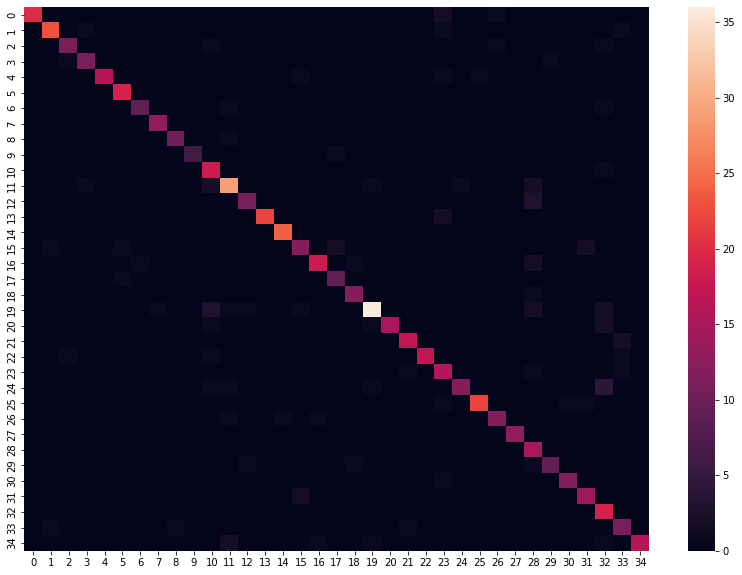

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(confusion_mat)

In [ ]:
print(f'Accuracy Dogs VS Cats {dog_vs_cat / validation_size * 100} %')
print(f'F1-score macro {sum(f1_average_macro) / len(f1_average_macro)}')
print(f'F1-score micro {sum(f1_average_micro) / len(f1_average_micro)}')

Accuracy Dogs VS Cats 98.5981308411215 %
F1-score macro 0.7904789122253073
F1-score micro 0.8616071428571429
